In [1]:
!pip install pyramid
!pip install pyramid-arima

    100% |████████████████████████████████| 327kB 29.7MB/s 
    100% |████████████████████████████████| 174kB 34.6MB/s 
    100% |████████████████████████████████| 122kB 34.1MB/s 
    100% |████████████████████████████████| 604kB 21.5MB/s 
    100% |████████████████████████████████| 7.4MB 6.4MB/s 
  Found existing installation: statsmodels 0.8.0
    Uninstalling statsmodels-0.8.0:
      Successfully uninstalled statsmodels-0.8.0


In [1]:
#os.chdir("godrive/app/predictDamage")

#!ls -l /home/
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [2]:
#  !ls -l drive/app/predictDamage
# !cd drive/app/predictDamage
# !pwd

import os
os.chdir("drive/Practice Challenges/Stock Price Prediction")
os.listdir()
# !cd drive/'LG- HackerEarth'/
# !ls -lrth 

# !pwd
# !cd drive/app

['NSE-TATAGLOBAL11.csv', 'Stock Price Prediction.ipynb']

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [0]:
#Setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [0]:
# for normalising Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [0]:
# Reading the CSV File
df = pd.read_csv('NSE-TATAGLOBAL11.csv')

In [7]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


###Columns:  
Open - Starting price of the day  
Close - Closing price of the day
High - Maximum Price of the share for the day  
Low - Minimum Price of the share for the day  
Last - Last Price of the share for the day  

####Profit or loss calculation is done based on the Closing price of the stock for the day, Hence, we are considering the closing price  as the target variable


In [0]:
# Setting Date as INDEX
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

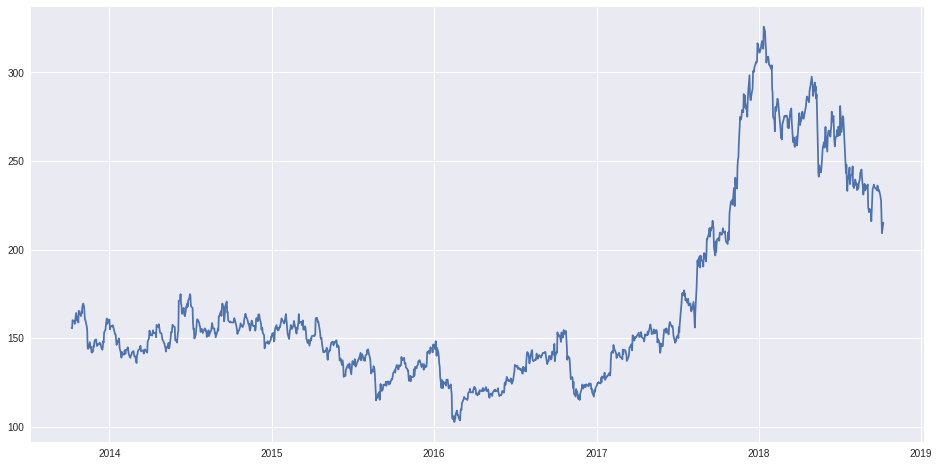

In [9]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'],label = 'Closing Price History')

### Method 1  :-  Moving Average

In Moving Average technique,  we will use the latest set of values for each prediction. In other words, For each subsequent step,the predicted values are taken into consideration while removing the oldest observation value from the set.

In [0]:
#Implementation

# Creating the DataFrame with the date and target variable
data = df.sort_index(ascending=True,axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [11]:
# Splitting dataset into train and test
train_size = int(len(new_data)*0.7)
train,test = new_data[:train_size],new_data[train_size:]

print('Observations: %d' % (len(new_data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))


Observations: 1235
Training Observations: 864
Testing Observations: 371


In [12]:
new_data.shape, train.shape, test.shape

((1235, 2), (864, 2), (371, 2))

In [13]:
train['Date'].min(), train['Date'].max(), test['Date'].min(), test['Date'].max()

(Timestamp('2013-10-08 00:00:00'),
 Timestamp('2017-04-10 00:00:00'),
 Timestamp('2017-04-11 00:00:00'),
 Timestamp('2018-10-08 00:00:00'))

In [0]:
# Make Predictions using Moving Average
preds = []
for i in range(0,len(test)):
    a = train['Close'][len(train)-len(test)+i:].sum() + sum(preds)
    b = a/len(test)
    preds.append(b)

In [15]:
# Calucalting RMSE
rms = np.sqrt(np.mean(np.power((np.array(test['Close'])-preds),2)))
rms

111.76037523262569

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


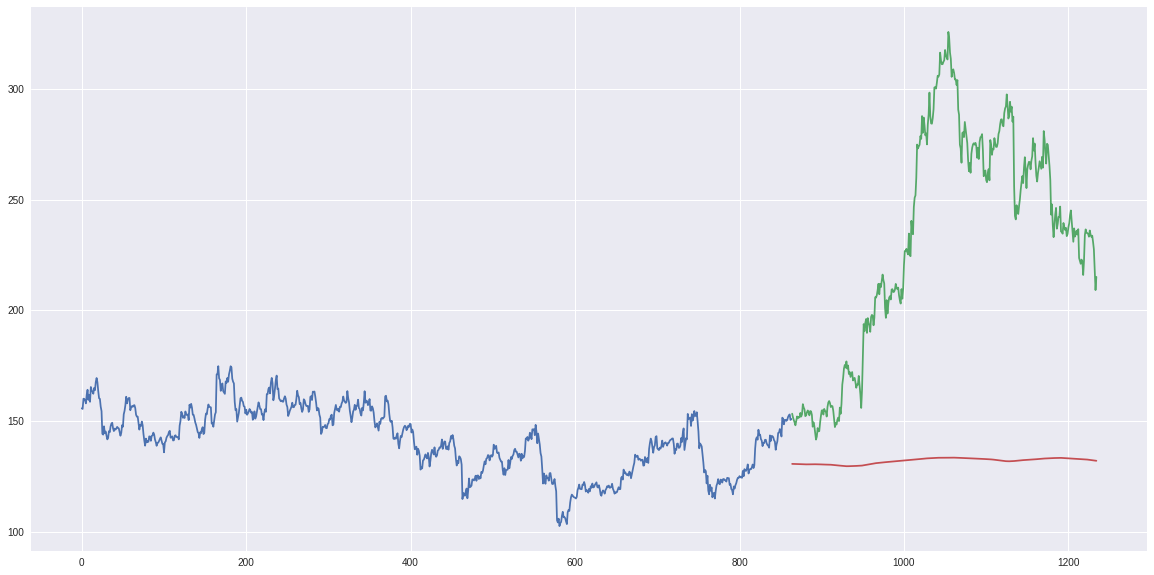

In [16]:
# Plotting the figure with the actual data and predictions
test['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])

### Method  2 :-  Linear Regression 

For the problem we dont have a set of independant values, So we are extracting features like day,month,year,week etc from the 'Date' column of the Data Set


In [0]:
# Setting Index as Date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index= df['Date']

# Sorting the Date column
data = df.sort_index(ascending=True,axis=0)

# Creating seperate datset with date and closing price as columns
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]


In [18]:
new_data.head()

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45


In [0]:
def is_month_end_method(month_end,day):
    if month_end == day:
        return 1
    else:
        return 0
    
def is_month_start_method(day):
    if day == 1:
        return 1
    else:
        return 0
    
# quater start - 1,4,7,10
def is_quarter_end_method(month):
    if month%3 == 0:
        return 1
    else:
        return 0
    
# quater end - 3,6,9,12    
def is_quarter_start_method(month):
    if month%3 == 1:
        return 1
    else:
        return 0

def is_year_start_method(month):
    if month == 1:
        return 1
    else:
        return 0
    
def is_week_day_method(dayOfWeek):
#     monday indicates 1 and friday indicates 5
    if int(dayOfWeek) >= 1 and int(dayOfWeek) <= 5:
        return 1
    else:
        return 0

In [20]:
from datetime import datetime
import calendar
print(calendar.monthrange(2018,11)[1])
year = lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).year
month = lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).month
day = lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).day
week_number = lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).strftime('%V')
day_of_week = lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).strftime('%w')
day_of_year = lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).strftime('%j')

seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).month-1)]

month_end = lambda x: calendar.monthrange(datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).year,datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S" ).month)[1]

new_data['year'] = new_data['Date'].map(year)
new_data['Dayofweek'] = new_data['Date'].map(day_of_week)
new_data['Month'] = new_data['Date'].map(month)
new_data['Day'] = new_data['Date'].map(day)
new_data['Week'] = new_data['Date'].map(week_number)
new_data['Dayofyear'] = new_data['Date'].map(day_of_year)
new_data['season'] = new_data['Date'].map(season)
new_data['month_end'] = new_data['Date'].map(month_end)
new_data['is_month_end'] = new_data.apply(lambda x: is_month_end_method(x['month_end'],x['Day']), axis=1)
new_data['is_month_start'] = new_data.apply(lambda x: is_month_start_method(x['Day']), axis=1)
new_data['is_quarter_start'] = new_data.apply(lambda x: is_quarter_start_method(x['Month']), axis=1)
new_data['is_quarter_end'] = new_data.apply(lambda x: is_quarter_end_method(x['Month']), axis=1)
new_data['is_year_start'] = new_data.apply(lambda x: is_year_start_method(x['Month']), axis=1)
new_data['is_week_day'] = new_data.apply(lambda x: is_week_day_method(x['Dayofweek']), axis=1)

del new_data['month_end']
del new_data['Day']
del new_data['Date']

# sleep: 12-5, 6-9: breakfast, 10-14: lunch, 14-17: dinner prep, 17-21: dinner, 21-23: deserts!
# times_of_day = [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5 ]
# time_of_day = lambda x: times_of_day[datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").hour]


# new_data['time_of_day'] = new_data['Date'].map(time_of_day)


30


In [21]:
new_data.head()

,Close,year,Dayofweek,Month,Week,Dayofyear,season,is_month_end,is_month_start,is_quarter_start,is_quarter_end,is_year_start,is_week_day
0,155.8,2013,2,10,41,281,3,0,0,1,0,0,1
1,155.55,2013,3,10,41,282,3,0,0,1,0,0,1
2,160.15,2013,4,10,41,283,3,0,0,1,0,0,1
3,160.05,2013,5,10,41,284,3,0,0,1,0,0,1
4,159.45,2013,1,10,42,287,3,0,0,1,0,0,1


In [0]:
train_size = int(len(new_data)*0.7)
train,test = new_data[:train_size],new_data[train_size:]


In [0]:
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_test = test.drop('Close', axis=1)
y_test = test['Close']

In [24]:
x_train.dtypes

year                 int64
Dayofweek           object
Month                int64
Week                object
Dayofyear           object
season               int64
is_month_end         int64
is_month_start       int64
is_quarter_start     int64
is_quarter_end       int64
is_year_start        int64
is_week_day          int64
dtype: object

In [25]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
# Results

#make predictions and find the rmse
preds = model.predict(x_test)
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

124.83492875751428

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


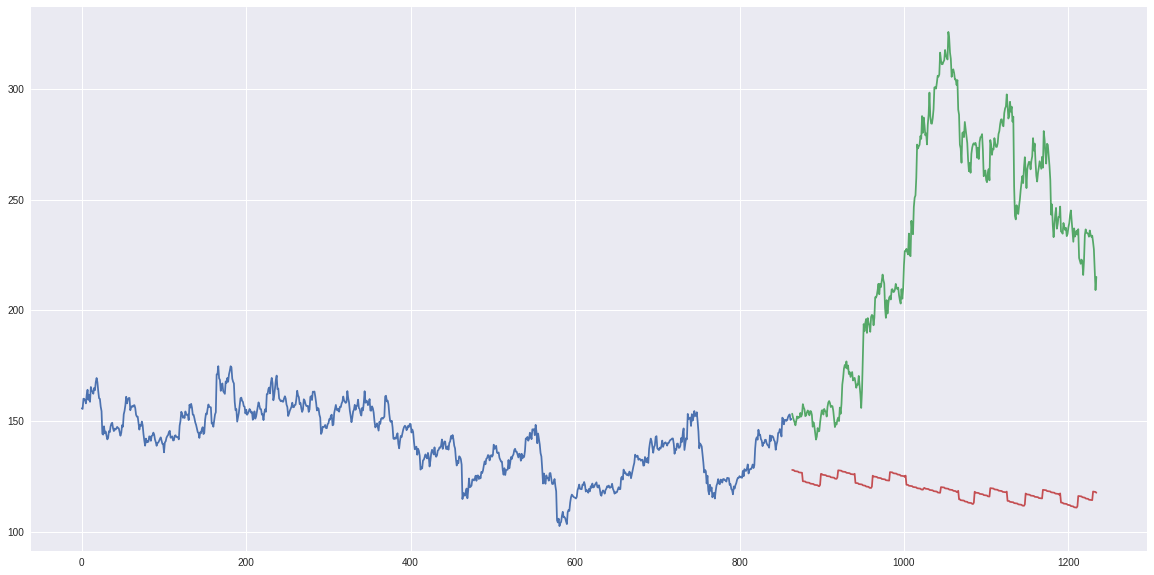

In [27]:
#plot
test['Predictions'] = 0
test['Predictions'] = preds

test.index = new_data[train_size:].index
train.index = new_data[:train_size].index

plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])

### K - Nearest Neighbours Method


In [0]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [29]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [30]:
# Results
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

107.15362646425714

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


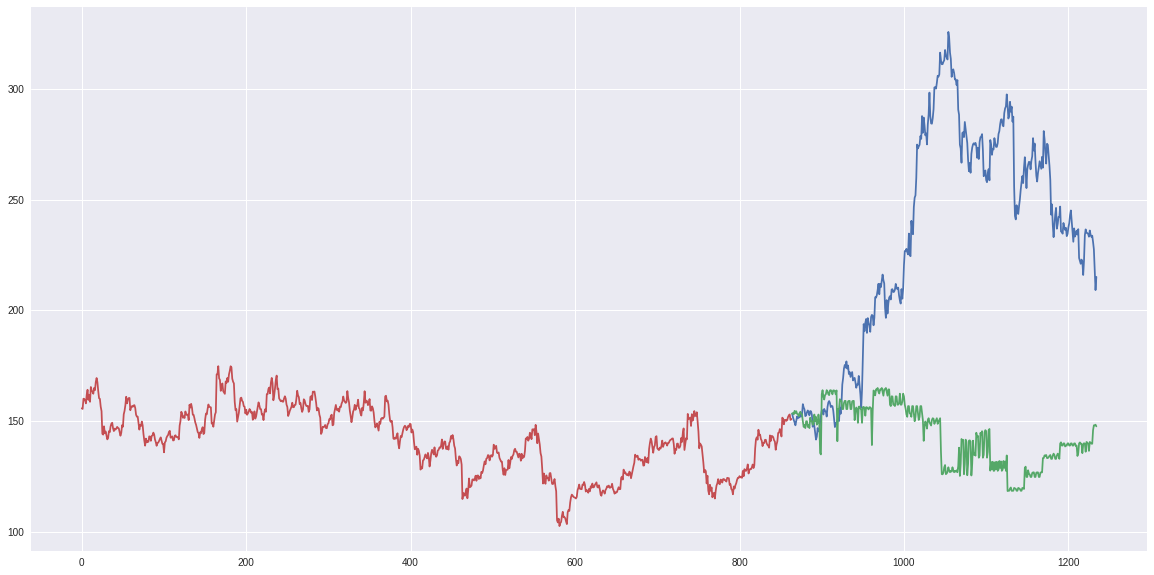

In [31]:
#plot
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(test[['Close', 'Predictions']])
plt.plot(train['Close'])

### Auto Arima Model
ARIMA is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:
- p (past values used for forecasting the next value)
- q (past forecast errors used to predict the future values)
- d (order of differencing)

In [32]:
# Implementation
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:train_size]
test = data[train_size:]

training = train['Close']
testing = test['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])


/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4106.138, BIC=4129.870, Fit time=12.670 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4665.361, BIC=4674.853, Fit time=0.115 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4416.893, BIC=4435.878, Fit time=1.934 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4104.299, BIC=4123.284, Fit time=6.663 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4105.238, BIC=4128.970, Fit time=9.230 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4665.825, BIC=4680.064, Fit time=0.482 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=4105.199, BIC=4128.931, Fit time=19.770 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4106.378, BIC=4134.856, Fit time=31.495 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=4103.183, BIC=4117.422, Fit time=4.571 seconds
Fit ARIMA: order=(0, 1, 0

In [33]:
rms=np.sqrt(np.mean(np.power((np.array(test['Close'])-np.array(forecast['Prediction'])),2)))
rms

77.25862738466307

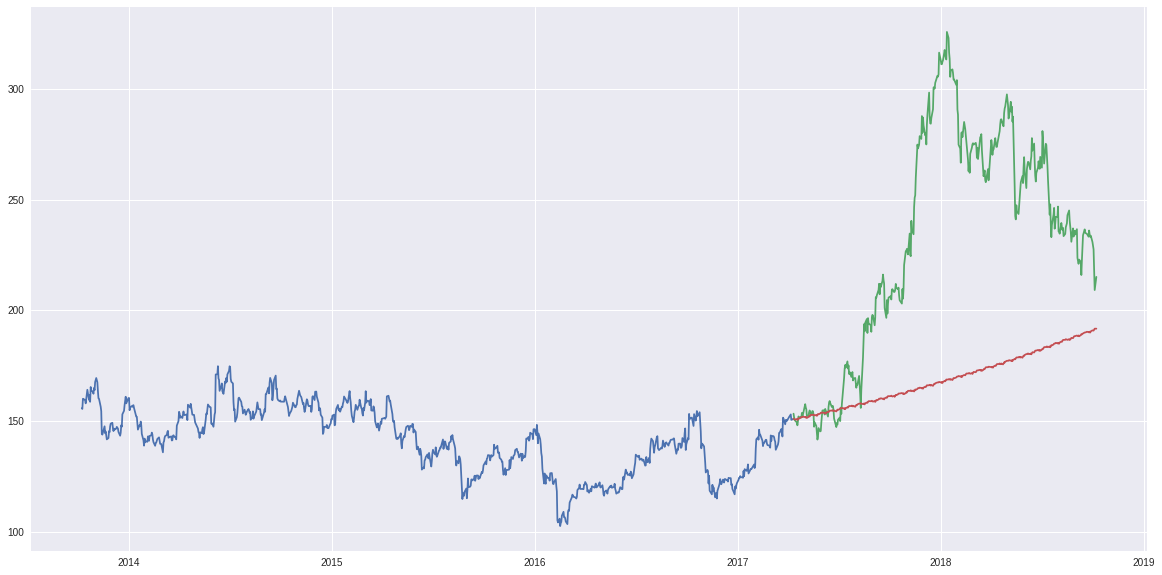

In [34]:
#plot
plt.plot(train['Close'])
plt.plot(test['Close'])
plt.plot(forecast['Prediction'])

###LSTM Implementation Using Keras


In [35]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [0]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]


In [0]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)


In [0]:
#creating train and test sets
dataset = new_data.values

train = dataset[0:train_size,:]
test = dataset[train_size:,:]


In [39]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [41]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 176s - loss: 8.3359e-04


In [0]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


array([2.248081488488509, 0.8308333613680929, -0.21141383144484394,
       -1.539876030965388, -2.3905155188491847, -0.8105990041860878,
       0.7749951329667226, 0.1014801107359915, 0.3814592208246381,
       -0.22333264401191855, 1.8760952883988296, 0.23460449870705702,
       1.0304436425305425, 5.860953170745063, 4.566463633267091,
       3.435759089081529, 0.8328772565327256, 0.6605514265307875,
       1.7439032190185628, 2.7181458521228024, 1.4958826175464424,
       -0.21115159195514366, 1.7860339957906035, 1.642300861433796,
       -0.16410233940774788, -5.285835155858251, -3.082567038001258,
       -5.065513926851821, -7.670638104065716, -11.195206278732684,
       -10.214096830909881, -6.1920965424706935, -8.066602121712066,
       -8.275878675878687, -4.3809354327979975, -1.3769109118198344,
       0.8644435426735981, 1.1904683815580483, -0.5585058452499823,
       1.7063049212344197, 1.1989383993554839, 0.5221278800235609,
       -2.149005016818734, 2.3707529269554186, 3.9

In [54]:
# results
rms=np.sqrt(np.mean(np.power(np.array(test['Close'])-np.array(forecast['Prediction']),2)))

# rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

77.25862738466306

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


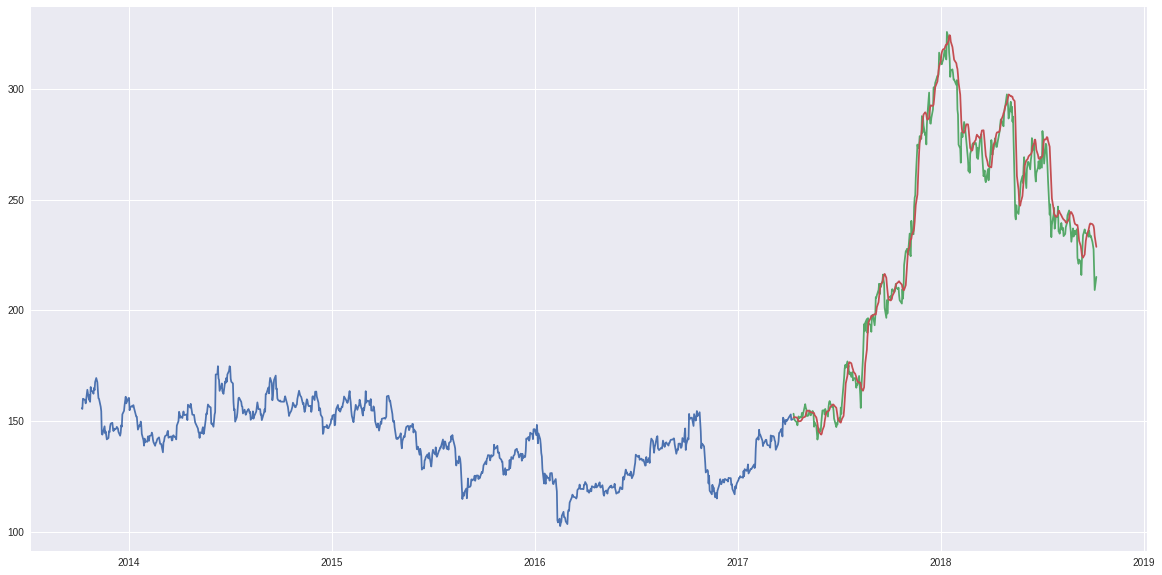

In [47]:
#for plotting
train = new_data[:train_size]
test = new_data[train_size:]
test['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])